# Uncovering Wonderland: Word Embeddings in Lewis Carroll’s Fantasy Novel

## Install packages and mount Google Drive

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 37.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 21.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 72.8 MB/s eta 0:00:00


In [ ]:
from google.colab import drive

import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer, PorterStemmer

import matplotlib.pyplot as plt
import numpy as np
import string
from collections import Counter
from wordcloud import WordCloud
from sklearn.manifold import TSNE

from gensim.test.utils import datapath
from gensim.models.keyedvectors import KeyedVectors
from gensim.models import Word2Vec, FastText

import torch
from torch.nn.functional import cosine_similarity

from transformers import BertModel, BertTokenizer, GPT2Model, GPT2Tokenizer

In [ ]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Preprocess the text corpus

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

def preprocess_text(text, to_lower=True, remove_punctuation=True, lemmatize=True, stem=True):
  # Replaces escape character with space
  text = text.replace("\n", " ")

  # Tokenize the text into sentences
  sentences = sent_tokenize(text)

  # Get the stopwords and punctuation
  stop_words = set(stopwords.words('english'))
  punctuation = set(string.punctuation + '”’“')

  # Initialize lemmatizer and stemmer
  lemmatizer = WordNetLemmatizer()
  stemmer = PorterStemmer()

  processed_text = []
  word_frequencies = {}

  for sentence in sentences:
    # Tokenize the sentence into words
    words = word_tokenize(sentence)

    processed_words = []

    for word in words:
      # Apply preprocessing steps
      if to_lower:
        word = word.lower()

      if remove_punctuation and word in punctuation:
        continue

      if lemmatize:
        word = lemmatizer.lemmatize(word)

      if stem:
        word = stemmer.stem(word)

      if word.lower() not in stop_words:
        processed_words.append(word)

        # Increment the word count
        word_frequencies[word] = word_frequencies.get(word, 0) + 1

    processed_text.append(processed_words)

  return processed_text, word_frequencies

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


## Train the models

In [ ]:
# Open the file "alice.txt" in read mode
f = open("/content/drive/MyDrive/STAI_NLP/alice.txt", "r")
raw_text = f.read()

processed_text, word_frequencies = preprocess_text(raw_text, lemmatize=False, stem=False)

# Create a list of models, each represented as a dictionary
models = [
	{
		'name': 'Word2Vec - CBOW',
		'model': Word2Vec(processed_text, min_count=1, vector_size=100, window=5)
	},
	{
		'name': 'Word2Vec - SG',
		'model': Word2Vec(processed_text, min_count=1, vector_size=100, window=5, sg=1)
	},
	{
		'name': 'FastText',
		'model': FastText(processed_text, min_count=1, vector_size=100, window=5)
	}
]

## Evaluate the models

### Word Similarity Evaluation

In [ ]:
def get_cosine_similarity(model, first_word, second_word):
  first_word_vector = torch.tensor(model['model'].wv[first_word])
  second_word_vector = torch.tensor(model['model'].wv[second_word])

  # Calculate the cosine similarity between the word vectors
  similarity = cosine_similarity(first_word_vector.unsqueeze(0), second_word_vector.unsqueeze(0))

  print(f"Cosine similarity between '{first_word}' and '{second_word}' ({model['name']}): {similarity.item()}")

for model in models:
  get_cosine_similarity(model, 'king', 'queen')
  get_cosine_similarity(model, 'king', 'pig')

Cosine similarity between 'king' and 'queen' (Word2Vec - CBOW): 0.9010434150695801
Cosine similarity between 'king' and 'pig' (Word2Vec - CBOW): 0.40751221776008606
Cosine similarity between 'king' and 'queen' (Word2Vec - SG): 0.9987632036209106
Cosine similarity between 'king' and 'pig' (Word2Vec - SG): 0.9977740049362183
Cosine similarity between 'king' and 'queen' (FastText): 0.9999634027481079
Cosine similarity between 'king' and 'pig' (FastText): 0.9991225004196167


In [ ]:
def get_most_similar_words(word):
  for model in models:
    # Get the most similar words
    most_similar_words = model['model'].wv.most_similar(word, topn=10)

    print(f"Most similar words to the word '{word}' ({model['name']}):")

    for w, similarity in most_similar_words:
      print(f"{w}: {similarity}")

    print('\n')

get_most_similar_words('king')
get_most_similar_words('queen')

Most similar words to the word 'king' (Word2Vec - CBOW):
alice: 0.927798330783844
one: 0.9200114607810974
said: 0.9194662570953369
would: 0.9109499454498291
went: 0.9101338386535645
way: 0.9047362804412842
began: 0.9044138789176941
head: 0.9040576815605164
time: 0.9036919474601746
turtle: 0.9036432504653931


Most similar words to the word 'king' (Word2Vec - SG):
one: 0.998951256275177
away: 0.9988194704055786
wish: 0.998818576335907
large: 0.9988184571266174
back: 0.9987983703613281
head: 0.9987773299217224
queen: 0.9987631440162659
alice: 0.9987543821334839
went: 0.9987301826477051
tone: 0.9987205266952515


Most similar words to the word 'king' (FastText):
looking: 0.9999955296516418
talking: 0.9999952912330627
thing: 0.9999951124191284
thinking: 0.9999948143959045
lying: 0.9999945759773254
going: 0.9999942183494568
making: 0.999994158744812
ring: 0.999994158744812
sing: 0.999994158744812
asking: 0.9999939799308777


Most similar words to the word 'queen' (Word2Vec - CBOW):
said: 0.

In [ ]:
for model in models:
  # Perform the wordsim353 test
  similarity = model['model'].wv.evaluate_word_pairs(datapath('wordsim353.tsv'))

  print(f"Word similarity evaluation ({model['name']})")
  print(similarity)

Word similarity evaluation (Word2Vec - CBOW)
(PearsonRResult(statistic=-0.0011690967814975146, pvalue=0.9950198356265567), SignificanceResult(statistic=-0.23855616051623307, pvalue=0.1962200602438135), 91.21813031161473)
Word similarity evaluation (Word2Vec - SG)
(PearsonRResult(statistic=-0.1309221642806748, pvalue=0.4826672497197068), SignificanceResult(statistic=-0.10425489009881024, pvalue=0.576750498765269), 91.21813031161473)
Word similarity evaluation (FastText)
(PearsonRResult(statistic=0.25660601361495783, pvalue=0.16347760224838917), SignificanceResult(statistic=0.05444646098003629, pvalue=0.7711252633040846), 91.21813031161473)


### Word Analogies Evaluation

In [ ]:
analogy_target = ['woman', 'king']
analogy_negative = ['man']

for model in models:
  # Perform the word analogy
  analogy_result = model['model'].wv.most_similar(positive=analogy_target, negative=analogy_negative, topn=10)

  print(f"Word analogy results for the 'king-queen' example ({model['name']}):")

  for word, similarity in analogy_result:
    print(f"{word}: {similarity}")

  print('\n')

Word analogy results for the 'king-queen' example (Word2Vec - CBOW):
gone: 0.5057081580162048
turtle: 0.5033323764801025
tone: 0.49841633439064026
poor: 0.4840110242366791
help: 0.4783926010131836
till: 0.47629624605178833
followed: 0.46927374601364136
mouse: 0.46795210242271423
course: 0.46790239214897156
caterpillar: 0.4663553535938263


Word analogy results for the 'king-queen' example (Word2Vec - SG):
—or: 0.8442721962928772
appearance: 0.8440398573875427
wasting: 0.8436475396156311
pause: 0.8391533493995667
m—: 0.8376484513282776
nevertheless: 0.8376323580741882
bad: 0.8373634815216064
stand: 0.8355075716972351
matters: 0.8352699279785156
dipped: 0.8350114226341248


Word analogy results for the 'king-queen' example (FastText):
watched: 0.9997643232345581
twinkling: 0.9997559785842896
lodging: 0.9997557401657104
pronounced: 0.9997555017471313
crawling: 0.9997543096542358
yelled: 0.999753475189209
telling: 0.9997532963752747
shilling: 0.9997522830963135
denying: 0.9997522234916687


### Visualization

In [ ]:
def get_sorted_common_words(nr_of_words):
  # Sort the word frequencies in descending order
  return dict(Counter(word_frequencies).most_common(nr_of_words))

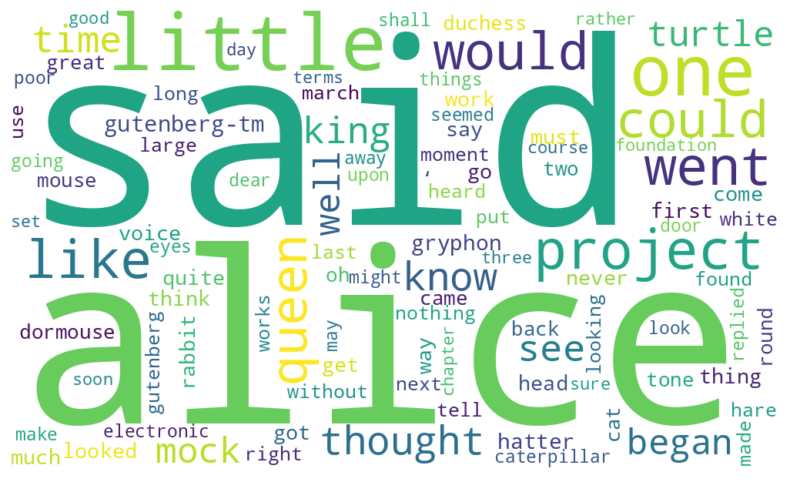

In [ ]:
# Create a WordCloud object
wordcloud = WordCloud(width=1000, height=600, background_color='white')

# Generate the word cloud
wordcloud.generate_from_frequencies(get_sorted_common_words(100))

# Plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

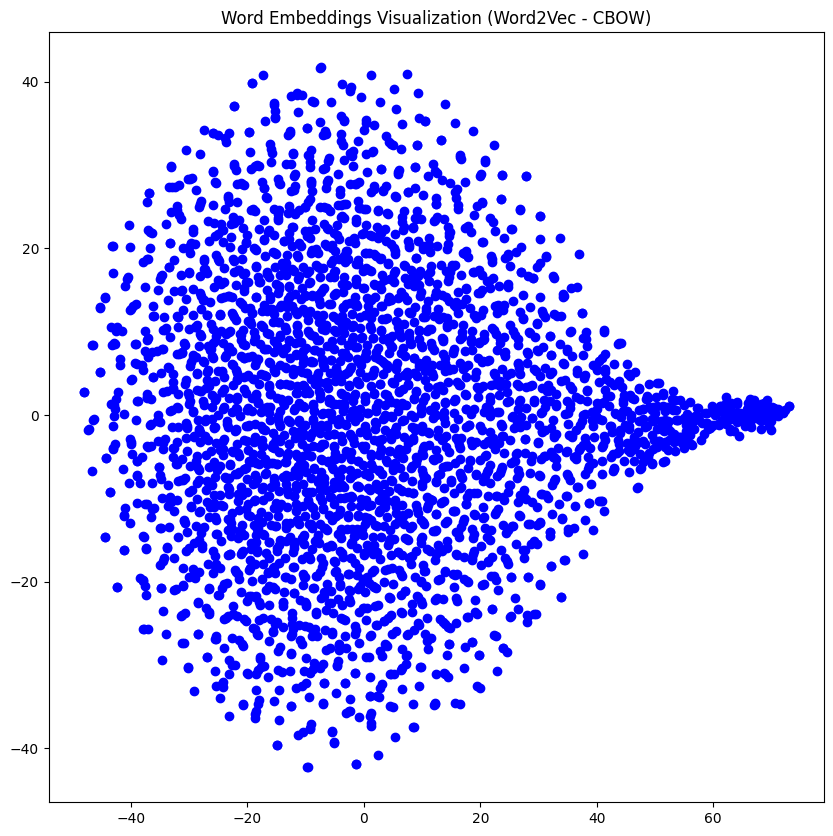

In [ ]:
# Collect the word embeddings from the models
embeddings = []
labels = []
model = models[0]

for word in model['model'].wv.index_to_key:
  embeddings.append(model['model'].wv[word])
  labels.append(word)

# Convert embeddings to a NumPy array
embeddings = np.array(embeddings)

# Reduce the dimensionality using t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(embeddings)

# Plot the embeddings
plt.figure(figsize=(10, 10))

for i, label in enumerate(labels):
  x, y = embeddings_2d[i]
  plt.scatter(x, y, color='blue')

plt.title(f"Word Embeddings Visualization ({model['name']})")
plt.show()

In [ ]:
def plot_words(model, words, title, colors=None):
  # Collect the word embeddings from the models
  embeddings = []
  labels = words

  for label in labels:
    embeddings.append(model['model'].wv[label])

  # Convert embeddings to a NumPy array
  embeddings = np.array(embeddings)

  # Reduce the dimensionality using t-SNE
  tsne = TSNE(n_components=2, perplexity=10, random_state=0)
  embeddings_2d = tsne.fit_transform(embeddings)

  # Plot the embeddings
  plt.figure(figsize=(10, 10))

  for i, label in enumerate(labels):
    x, y = embeddings_2d[i]

    c = colors[i] if not colors == None else None

    plt.scatter(x, y, s=word_frequencies[label] * 10, c=c)
    plt.annotate(
      label,
      xy=(x, y),
      xytext=(5, 8),
      textcoords='offset points',
      ha='right',
      va='bottom',
      bbox=dict(
        boxstyle='round,pad=0.25',
        fc='white',
        edgecolor='black',
        lw=1
      )
    )

  plt.title(f"Word Embeddings Visualization ({title})")
  plt.show()

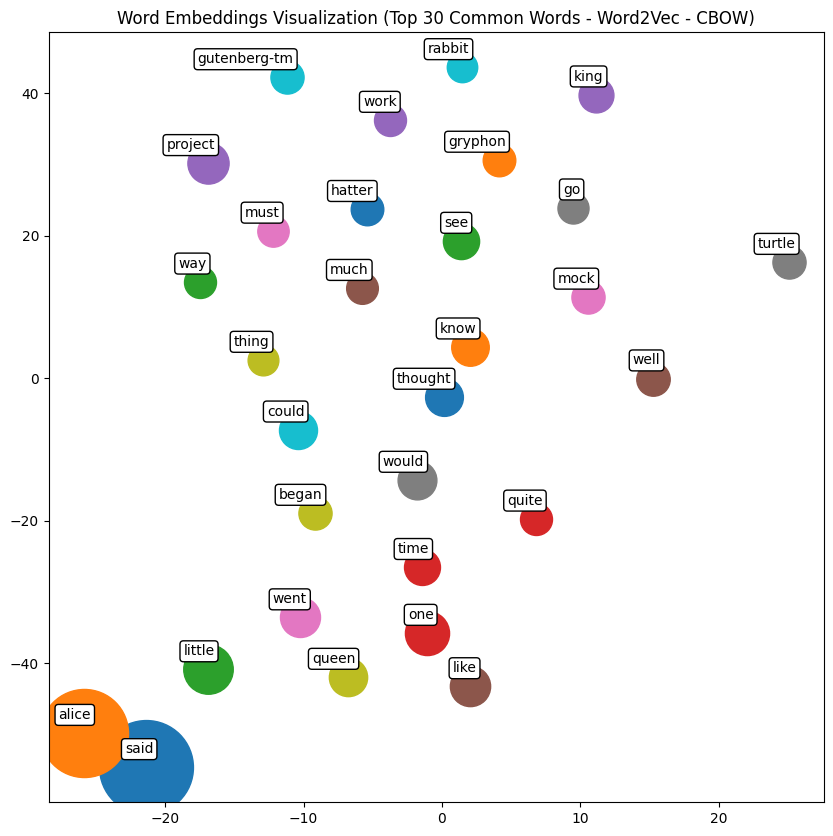

In [ ]:
# Plot the top 30 common words
model = models[0]
nr_of_words = 30

plot_words(
  model,
  list(get_sorted_common_words(nr_of_words).keys()),
  f"Top {nr_of_words} Common Words - {model['name']}"
)

<ipython-input-13-c02c997ee3da>:24: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(x, y, s=word_frequencies[label] * 10, c=c)


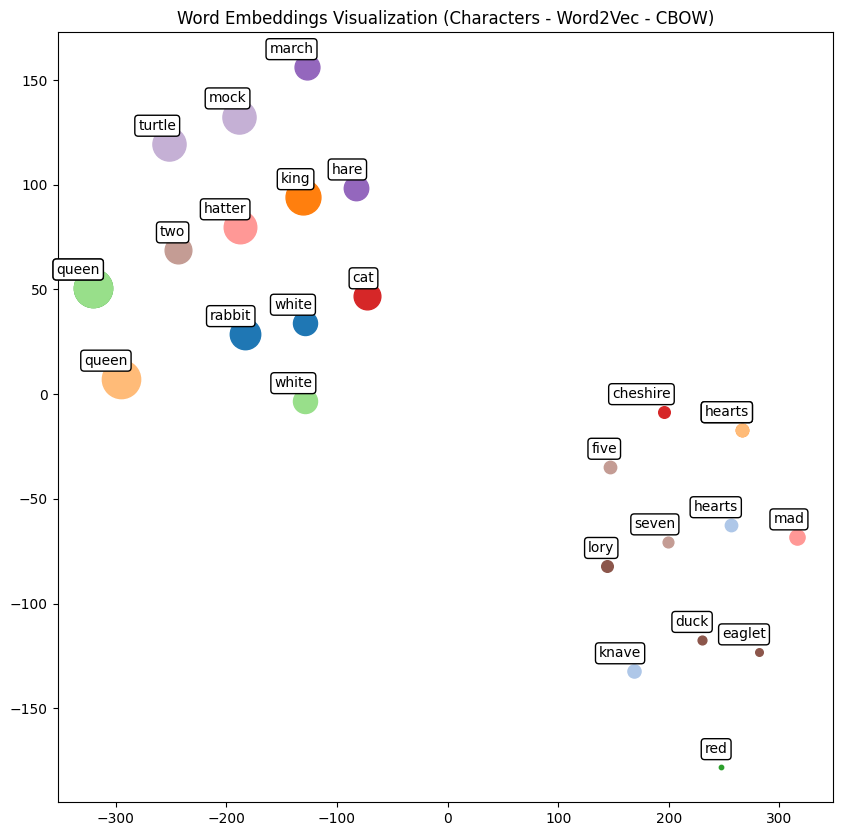

In [ ]:
# Plot the characters
unique_colors = plt.cm.tab20(range(12))

plot_words(
  models[0],
  [
    'white', 'rabbit',
    'hearts', 'knave',
    'hearts', 'king',
    'hearts', 'queen',
    'red', 'queen',
    'white', 'queen',
    'cheshire', 'cat',
    'mad', 'hatter',
    'march', 'hare',
    'mock', 'turtle',
    'duck', 'lory', 'eaglet',
    'two', 'five', 'seven'
  ],
  f"Characters - {model['name']}",
  colors=[
    unique_colors[0], unique_colors[0],
    unique_colors[1], unique_colors[1],
    unique_colors[2], unique_colors[2],
    unique_colors[3], unique_colors[3],
    unique_colors[4], unique_colors[4],
    unique_colors[5], unique_colors[5],
    unique_colors[6], unique_colors[6],
    unique_colors[7], unique_colors[7],
    unique_colors[8], unique_colors[8],
    unique_colors[9], unique_colors[9],
    unique_colors[10], unique_colors[10], unique_colors[10],
    unique_colors[11], unique_colors[11], unique_colors[11]
  ]
)

## Transformer models

In [ ]:
def train_transformer_model(name, model, tokenizer):
  # Split the tokens into chunks of maximum length 512 or 1024
  max_length = 512

  if name == 'GPT2':
    # Add a padding token to the tokenizer
    tokenizer.add_special_tokens({'pad_token': '[PAD]'})

    # Split the tokens into chunks of maximum length 512
    max_length = 1024

  # Tokenize the text into tokens
  tokens = tokenizer.tokenize(raw_text)

  chunks = [tokens[i:i+max_length] for i in range(0, len(tokens), max_length)]

  # Create lists to store the embeddings and corresponding words
  embeddings = []
  words = []

  # Process each chunk separately
  for chunk in chunks:
    # Convert the chunk back to text
    chunk_text = ' '.join(chunk)

    # Tokenize the chunk text
    encoded_inputs = tokenizer.encode_plus(
      chunk_text,
      add_special_tokens=True,
      truncation=True,
      max_length=max_length,
      padding='max_length',
      return_tensors='pt'
    )

    # Get the input tensors
    input_ids = encoded_inputs['input_ids']
    attention_mask = encoded_inputs['attention_mask']

    # Pass the input tensors through the BERT model
    with torch.no_grad():
      outputs = model(input_ids=input_ids, attention_mask=attention_mask)

    # Retrieve the last hidden state (word embeddings) from the model outputs
    last_hidden_state = outputs.last_hidden_state

    # Append the embeddings and corresponding words to the lists
    embeddings.append(last_hidden_state)
    words.extend(chunk)

  # Concatenate the embeddings and reshape into a single tensor
  embeddings = torch.cat(embeddings, dim=1)

  if name == 'GPT2':
    # Convert tokens back to string representation
    words = tokenizer.convert_tokens_to_string(words).split()

  # Save the model
  model.save_pretrained(f"/content/drive/MyDrive/STAI_NLP/{name}")

  return model, words, embeddings

In [ ]:
# Initialize the transformer models
initial_transformer_models = [
  {
    'name': 'BERT',
    'model': BertModel.from_pretrained('bert-base-cased'),
    'tokenizer': BertTokenizer.from_pretrained('bert-base-cased')
  },
  {
    'name': 'GPT2',
    'model': GPT2Model.from_pretrained('gpt2'),
    'tokenizer': GPT2Tokenizer.from_pretrained('gpt2')
  }
]

transformer_models = []

# Train the transformer models
for transformer_model in initial_transformer_models:
  model, words, embeddings = train_transformer_model(
    transformer_model['name'],
    transformer_model['model'],
    transformer_model['tokenizer']
  )

  transformer_models.append({
    'name': transformer_model['name'],
    'model': model,
    'words': words,
    'embedding': embeddings,
  })

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


## Evaluate the transformer models

In [ ]:
def get_word_embedding(transformer_model, word):
  # Get the word index
  word_index = transformer_model['words'].index(word)

  return transformer_model['embedding'][:, word_index, :]

def get_transformer_cosine_similarity(transformer_model, first_word, second_word):
  # Get the embeddings for the words
  first_word_embedding = get_word_embedding(transformer_model, first_word)
  second_word_embedding = get_word_embedding(transformer_model, second_word)

  # Calculate the cosine similarity
  similarity = cosine_similarity(
    first_word_embedding,
    second_word_embedding,
    dim=1
  )

  print(f"Cosine similarity between '{first_word}' and '{second_word}' ({transformer_model['name']}): {similarity.item()}")

for transformer_model in transformer_models:
  get_transformer_cosine_similarity(transformer_model, 'King', 'Queen')
  get_transformer_cosine_similarity(transformer_model, 'King', 'Pig')

Cosine similarity between 'King' and 'Queen' (BERT): 0.2423391044139862
Cosine similarity between 'King' and 'Pig' (BERT): 0.16726845502853394
Cosine similarity between 'King' and 'Queen' (GPT2): 0.8085967898368835
Cosine similarity between 'King' and 'Pig' (GPT2): 0.8530164957046509
